# Лекция 3
## Модели ARIMA и GARCH

In [2]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [5]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

## В чем суть

Будем представлять временной ряд $y_t$ в виде

$y_t = T + S + E$

где T - тренд, S - сезонная компонента, E - ошибка прогноза

Будем рассматривать разные "порождающие" модели для рядов. Интуитивно - если ряд хорошо описывается моделью, то остатки - независимые и одинаково распределенные

## Белый шум и случайные блуждания

Первая модель - которую мы рассмотрим - белый шум.

$y_t = E$

Results of Dickey-Fuller Test:
Test Statistic                 -32.814024
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64


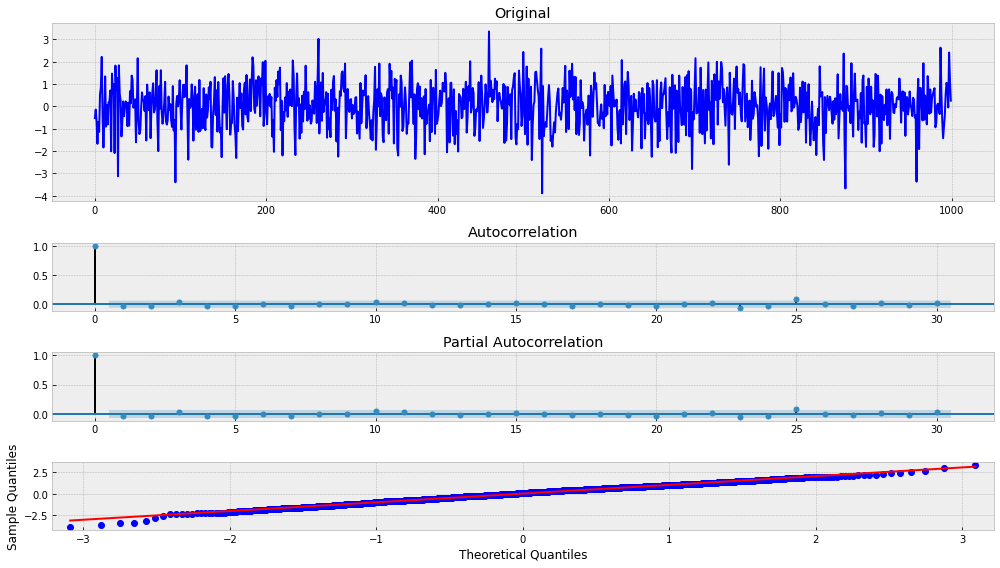

In [6]:
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

## Random Walk

### Следующая модель - это модель случайного блуждания.

$y_t = y_{t-1} + \epsilon_{t}$

где $\epsilon_{t}$ - белый шум
Особенность случайного блуждания в том, что он не стационарен, т.е. его свойства меняются со временем и предсказать его невозможно

## Практика - реализуйте процесс случайного блуждания

In [10]:
n_samples = 100

In [11]:
eps = np.random.normal(size=n_samples)
x = [0 + eps[0]]
for i in range(1, n_samples):
    x.append(x[i-1] + eps[i])

In [12]:
x = np.array(x)

In [ ]:
tsplot(x, lags=30)

Results of Dickey-Fuller Test:
Test Statistic                 -0.308951
p-value                         0.924227
#Lags Used                      0.000000
Number of Observations Used    99.000000
Critical Value (1%)            -3.498198
Critical Value (5%)            -2.891208
Critical Value (10%)           -2.582596
dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                  -2.438594
p-value                          0.131138
#Lags Used                       0.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64


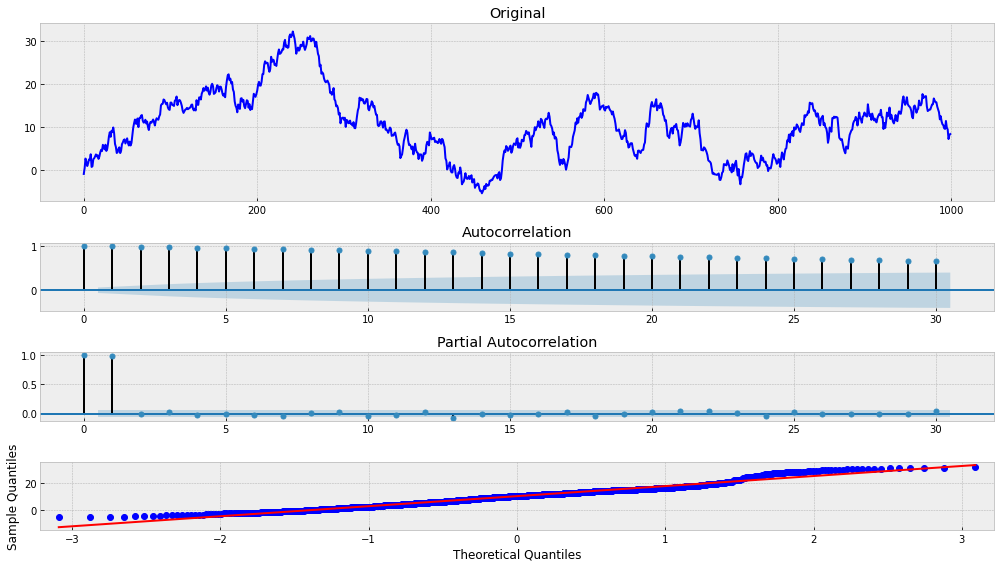

In [13]:
x = np.random.normal(size=1000)
x = np.cumsum(x)
tsplot(x, lags=30)

Давайте проверим, подходит ли модель случайного блуждания под сгенерированные данные. Для этого надо из текущего измерения вычесть предыдущие и посмотреть остатки

In [ ]:
tsplot(np.diff(x), lags=30)

Ура! Однако для реальных данных такой модели конечно не достаточно.

# AR(p)

Авторегрессионная модель — модель временных рядов, в которой значения временного ряда в данный момент линейно зависят от предыдущих значений этого же ряда. Авторегрессионный процесс порядка p (AR(p)-процесс) определяется следующим образом

$y_t = c + \sum_{i=1}^P a_i y_{t-i} + \epsilon_t$

где $\epsilon_t$ - белый шум

Сделаем симуляцию процесса AR(1) и посмотрим, сумеет ли модель AR правильно подобрать коэффициенты

Results of Dickey-Fuller Test:
Test Statistic                -1.877613e+01
p-value                        2.024692e-30
#Lags Used                     0.000000e+00
Number of Observations Used    9.990000e+02
Critical Value (1%)           -3.436913e+00
Critical Value (5%)           -2.864437e+00
Critical Value (10%)          -2.568313e+00
dtype: float64


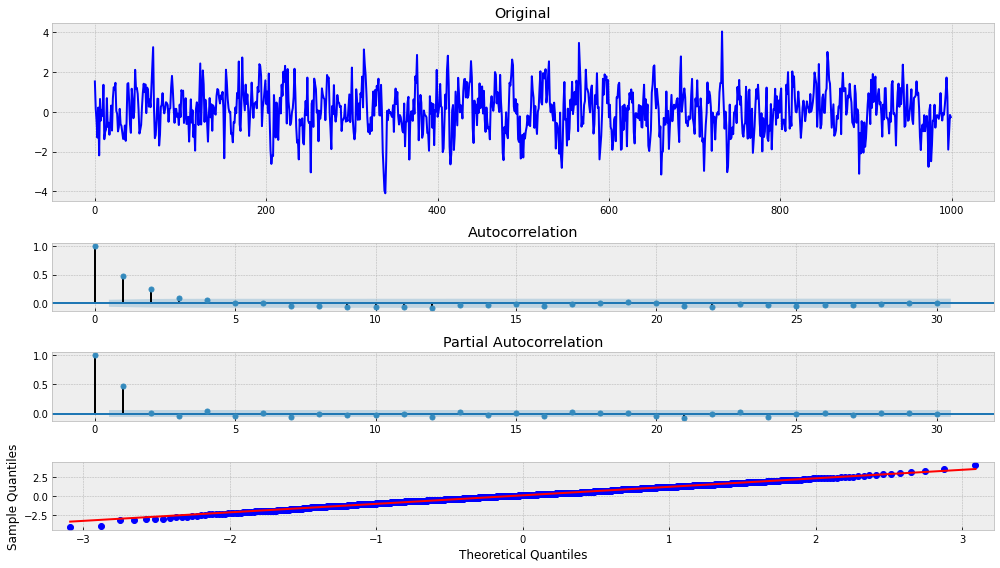

In [14]:
np.random.seed(1)
n_samples = int(1000)
a = 0.5
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
tsplot(x, lags=30)

In [15]:
mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
print('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order))
print('\ntrue alpha = {} | true order = {}'.format(a, true_order))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)



alpha estimate: 0.48076 | best lag order = 1

true alpha = 0.5 | true order = 1


In [17]:
mdl.params

array([0.48076147])

Results of Dickey-Fuller Test:
Test Statistic                 -31.856304
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    998.000000
Critical Value (1%)             -3.436919
Critical Value (5%)             -2.864440
Critical Value (10%)            -2.568314
dtype: float64


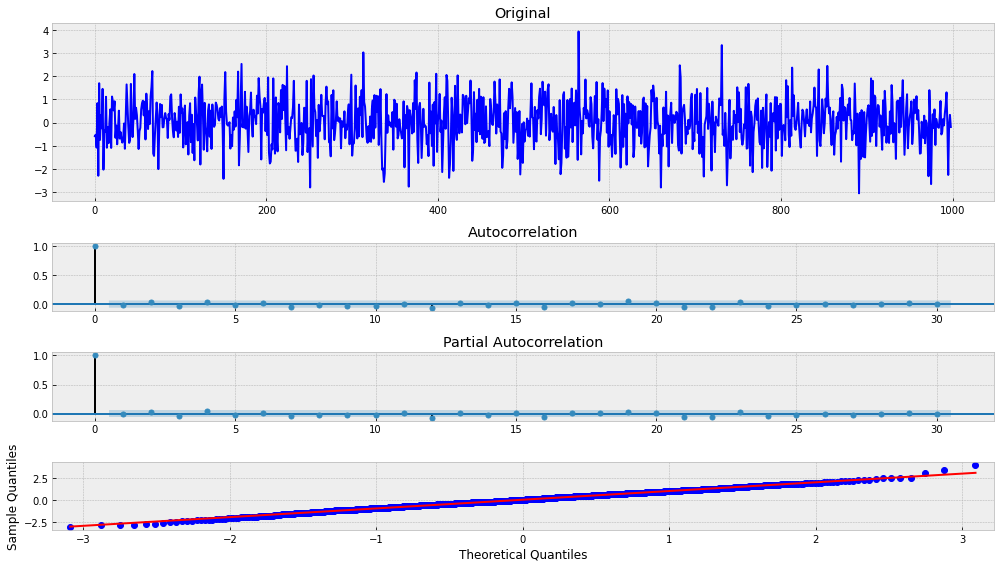

In [18]:
tsplot(mdl.resid, lags=30)

## Практика - сделайте симуляцию процесса AR(2) с параметрами 0.6 и 0.3 и посмотрите, сумеет ли модель AR правильно подобрать коэффициенты

Results of Dickey-Fuller Test:
Test Statistic                -8.126164e+00
p-value                        1.121702e-12
#Lags Used                     0.000000e+00
Number of Observations Used    9.990000e+02
Critical Value (1%)           -3.436913e+00
Critical Value (5%)           -2.864437e+00
Critical Value (10%)          -2.568313e+00
dtype: float64


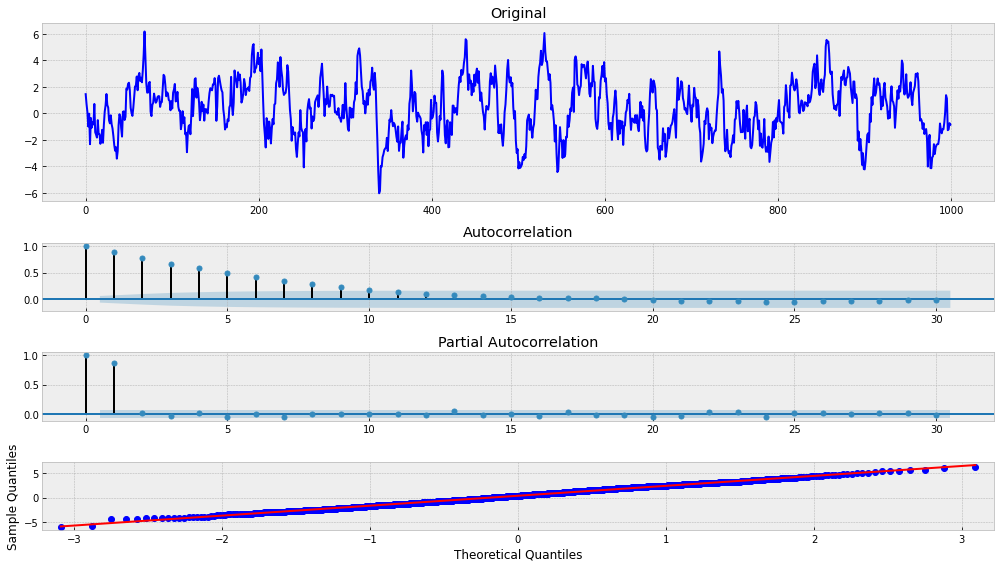

In [20]:
np.random.seed(1)
n_samples = int(1000)
a1 = 0.3
a2 = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a1*x[t-1] + a2*x[t-1] + w[t]
    
tsplot(x, lags=30)

In [21]:
mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
print('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order))
print('\ntrue alpha = {} | true order = {}'.format(a, true_order))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)



alpha estimate: 0.88005 | best lag order = 1

true alpha = 0.5 | true order = 1


Results of Dickey-Fuller Test:
Test Statistic                -6.988709e+00
p-value                        7.845875e-10
#Lags Used                     1.000000e+00
Number of Observations Used    9.980000e+02
Critical Value (1%)           -3.436919e+00
Critical Value (5%)           -2.864440e+00
Critical Value (10%)          -2.568314e+00
dtype: float64


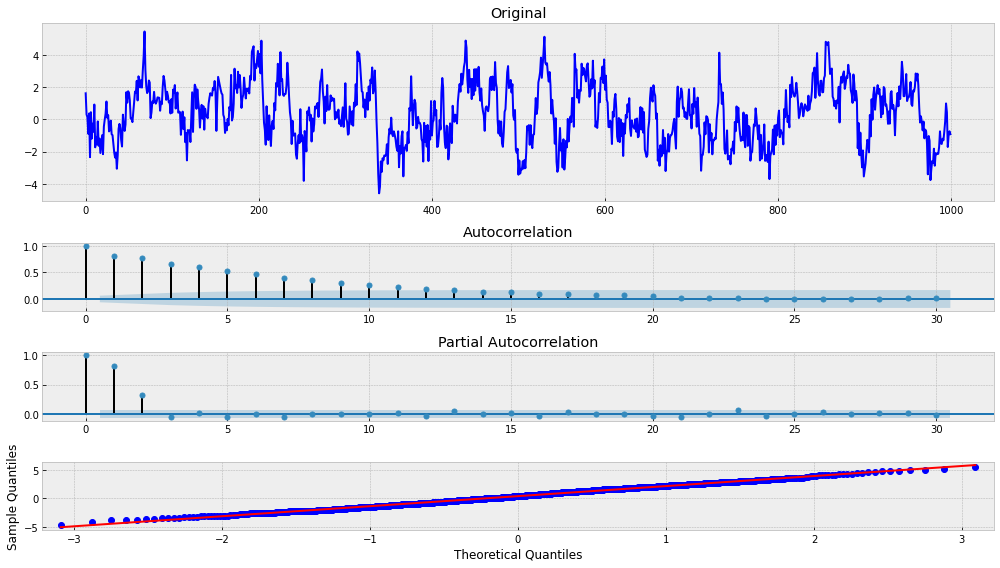

In [22]:
np.random.seed(1)
n_samples = int(1000)
a1 = 0.6
a2 = 0.3

x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a1*x[t-1] + a2*x[t-2] + w[t]
    
tsplot(x, lags=30)

In [23]:
mdl = smt.AR(x).fit(maxlag=3, trend='nc')

print('\nalpha estimate: {}'.format(mdl.params))


alpha estimate: [ 0.57237228  0.34300155 -0.0433057 ]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


Results of Dickey-Fuller Test:
Test Statistic                 -31.609276
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    996.000000
Critical Value (1%)             -3.436933
Critical Value (5%)             -2.864446
Critical Value (10%)            -2.568317
dtype: float64


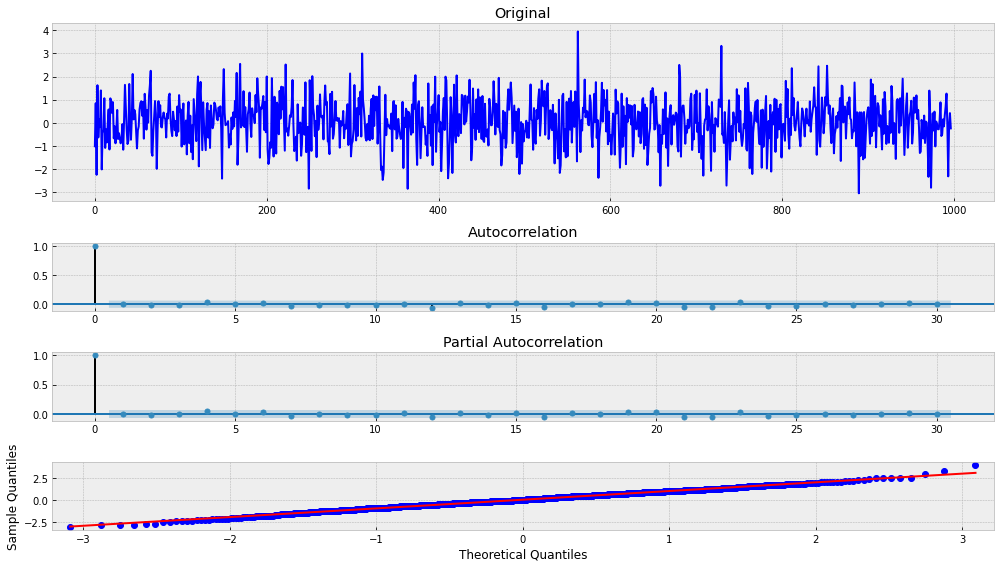

In [24]:
tsplot(mdl.resid, lags=30)

In [ ]:
series = pd.read_csv("Series/international-airline-passengers.csv")['Count']
tsplot(series)

In [ ]:
series = pd.read_csv("Series/international-airline-passengers.csv")['Count']
series = boxcox(series, 0)

In [ ]:
tsplot(series)

In [ ]:
mdl = smt.AR(series).fit(maxlag=30, ic='aic', trend='nc')
print(mdl.params)

In [ ]:
tsplot(mdl.resid)

In [ ]:
series_diffed = np.diff(series)
series_diffed = series_diffed[12:] - series_diffed[:-12]
tsplot(series_diffed)

In [ ]:
mdl_diffed = smt.AR(series_diffed).fit(maxlag=30, ic='aic', trend='nc')
print(mdl_diffed.params)

In [ ]:
tsplot(mdl_diffed.resid)

## MA(q)
В настоящий момент будем говорить про модель MA(q) - как про модель авторегресии на случайном шуме

$y_t = \sum_{j=0}^{Q} b_j \epsilon_{t-j}$

## ARMA(p,q)

Модель ARMA(p, q) представляет собой соединение двух моделей:
- AR(P) - авторегрессии на знанениях временного ряда
- MA(q) - авторегрессии на ошибках первой

AR(p) пытается предсказать "значение" временного ряда, а MA(q) пытается поймать шоковые явления, наблюдаемые в оставшемся случайном шуме.

$y_t = \sum_{i=1}^P a_i x_{t-i} + \sum_{i=1}^Q b_i \epsilon_{t-i} + \epsilon_t + c$

Сделаем симуляцию процесса ARMA

Results of Dickey-Fuller Test:
Test Statistic                -1.789014e+01
p-value                        2.979789e-30
#Lags Used                     1.500000e+01
Number of Observations Used    4.984000e+03
Critical Value (1%)           -3.431663e+00
Critical Value (5%)           -2.862120e+00
Critical Value (10%)          -2.567079e+00
dtype: float64
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7105.938
Method:                           mle   S.D. of innovations              1.002
Date:                Fri, 20 Nov 2020   AIC                          14221.876
Time:                        19:54:10   BIC                          14254.462
Sample:                             0   HQIC                         14233.297
                                                                              
              

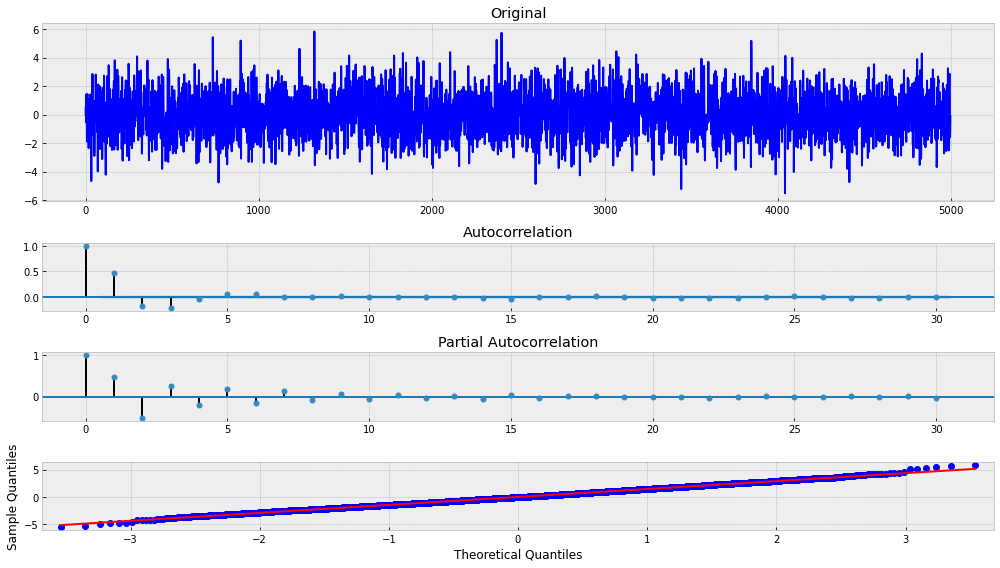

In [25]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
tsplot(arma22, lags=max_lag)

mdl = smt.ARMA(arma22, order=(2, 2)).fit(maxlag=max_lag, method='mle', trend='nc', burnin=burn)
print(mdl.summary())

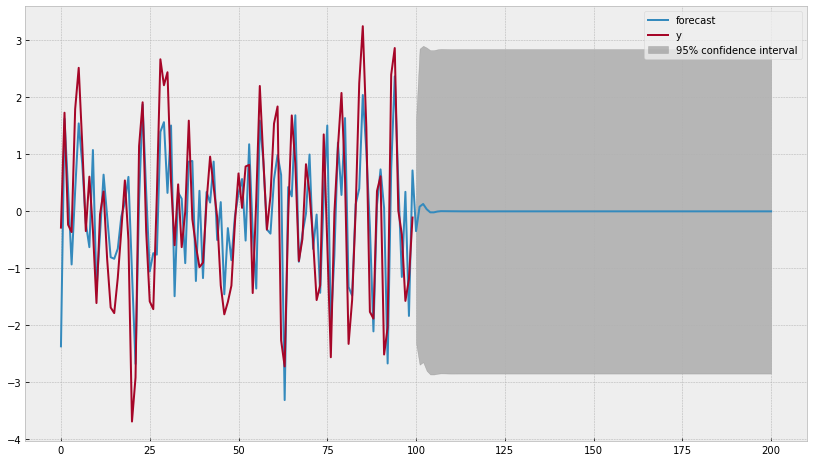

In [26]:
with plt.style.context(style='bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    mdl.plot_predict(start=4900, end=5100, ax=ax)

In [27]:
mdl.aic

14221.876194276472

p, q - гипер параметры => их можно подбирать. Как выбрать лучшие? AIC - Информационный критерий Акаике

## Практика! Реализуйте подбор гиперпараметров модели
Информационный критерий живет в вовзращаемом значении fit (у ARMA), чем меньше - тем лучше модель

In [ ]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
tsplot(arma22, lags=max_lag)

mdl = smt.ARMA(arma22, order=(2, 2)).fit(maxlag=max_lag, method='mle', trend='nc', burnin=burn)
print(mdl.summary())

In [31]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for j in range(5):
        test_mdl = smt.ARMA(arma22, order=(i, j)).fit(maxlag=max_lag, method='mle', trend='nc', burnin=burn)
        test_aic = test_mdl.aic
        if test_aic < best_aic:
            best_aic = test_aic
            best_order = (i, j)
            best_mdl = test_mdl

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

ValueError: Estimation requires the inclusion of least one AR term, MA term, a constant or an exogenous variable.

In [ ]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for j in range(5):
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i, j)).fit(maxlag=max_lag, method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            print('aic: {:6.5f} | order: {}'.format(tmp_aic, (i, j)))
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

Применим модель ARMA к нашей TS

In [ ]:
series = pd.read_csv("Series/international-airline-passengers.csv")['Count']
series = boxcox(series, 0)
series = series[12:] - series[:-12]
series = series[1:] - series[:-1]
tsplot(series)

In [ ]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for j in range(5):
        try:
            tmp_mdl = smt.ARMA(series, order=(i, j)).fit(
                method='mle', trend='nc'
            )
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

In [ ]:
mdl = smt.ARMA(series, order=(4, 4)).fit(
                method='mle', trend='nc'
            )
tsplot(mdl.resid)

Хотя по критериям модель выглядит "более-менее" нормально, она все еще не похожа на случайный шум.

In [ ]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    mdl.plot_predict(0, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

## ARIMA (p,d,q)

ARIMA - естественное расширение модели ARMA. Как мы уже хорошо знаем - многие временные ряды не стационарны, но они могут такими стать в результате операции дифференцирования. В модели ARIMA "дифференцирование" (в количестве d-раз) вносится в саму модель


$\delta^p y_t = c + \sum_{i=1}^p a_i \delta^d y_{t-i} + \sum_{j=1}^q b_j \epsilon_{t-j} + \epsilon_t$

In [ ]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

In [ ]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(0, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

Другие вариации для класса ARMA:
- SARIMA - арима с учетом сезонности
- ARIMAX/SARIMAX

In [ ]:
series = pd.read_csv("Series/international-airline-passengers.csv")['Count']
series = boxcox(series, 0)
tsplot(series)

In [ ]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

## ARCH

AutoRegressive Conditional Heteroscedasticit - пытаемся объяснить дисперсию в ряде через предыдущие значения (применяя к ним AR)

Пусть временной ряд представляется в таком виде:

$u_t = \epsilon_t * \sqrt{\alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2}$

Тогда условная дисперсия ряда будет равна

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2$

Получили модель ARCH(q) условной дисперсии. Требуем, чтобы все коэффициенты были больше 0 (иначе может получится отрицательная дисперсия)

In [ ]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 is between 0 and 1 then yt is white noise

np.random.seed(13)

a0 = 2
a1 = 5.5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(Y, lags=30)

## GARCH

Добавляем зависимость от прошлых значений самой условной дисперсии. Получаем модель GARCH(p, q)

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2$

GARCH - по сути - модель ARMA примененная к дисперсии ряда

In [35]:
!pip install arch

In [36]:
from arch import arch_model

## Практика! Реализуйте процесс GARCH, нарисуйте его график, примените к нему модель ARIMA и посмотрите на график остатков

Results of Dickey-Fuller Test:
Test Statistic                  -96.275609
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    9999.000000
Critical Value (1%)              -3.431004
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64


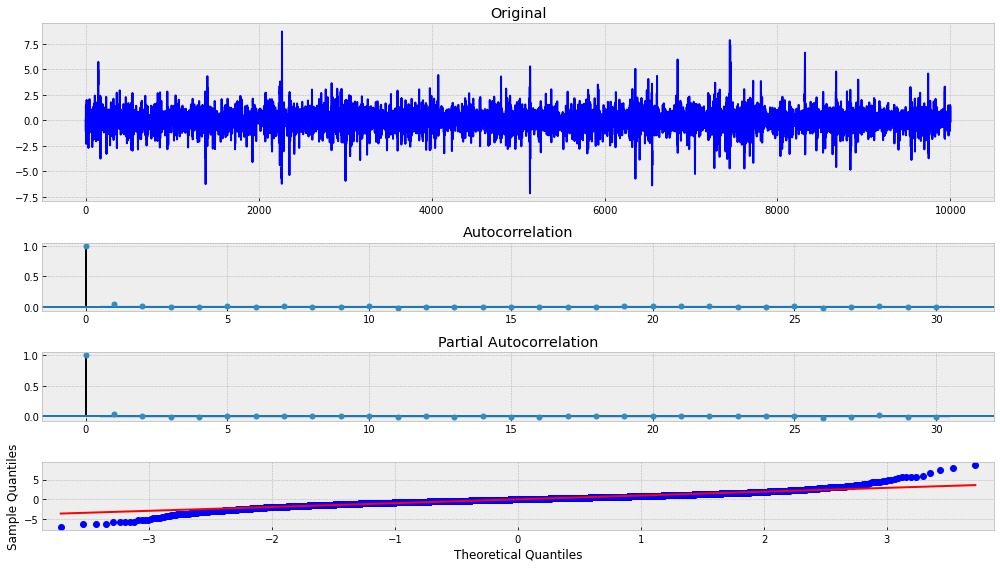

In [37]:
# Simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

tsplot(eps, lags=30)

In [38]:
am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     34,   Neg. LLF: 13129.78620620694
Iteration:     10,   Func. Count:     62,   Neg. LLF: 12237.312781005436
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12237.303267319123
            Iterations: 13
            Function evaluations: 76
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.3
Distribution:                  Normal   AIC:                           24482.6
Method:            Maximum Likelihood   BIC:                           24511.4
                                        No. Observations:                10000
Date:                Fri, Nov 20 2020   Df Residuals:                     9996
Time:        

# Продолжаем анализировать полеты

Применим ARIMA к нашему временному ряду

In [ ]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

aic, order, mdl = _get_best_model(series)

In [ ]:
tsplot(mdl.resid)

Применим GARCH

In [ ]:
series = series[12:] - series[:-12]
series = series[1:] - series[:-1]

In [ ]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = 4
o_ = 0
q_ = 4

# Using student T distribution usually provides better fit
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

In [ ]:
tsplot(res.resid)

## Проведем анализ для monthly-boston-armed-robberies-j

In [ ]:
new_series = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")["Count"].values.astype('float64')
new_series = boxcox(new_series, 0)
new_series = new_series[1:] - new_series[:-1]
tsplot(new_series)

In [ ]:
aic, order, mdl = _get_best_model(new_series)


In [ ]:
tsplot(mdl.resid)

In [ ]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(new_series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

In [ ]:
tsplot(res.resid)

## По простому

Такой подход является не совсем корректным (для прогнозирования свойств ВР), но он часто позволяет получать неплохие результаты в сжатые сроки

Генерируем большое количество фичей для нашего временного ряда

In [ ]:
series = pd.read_csv("Series/international-airline-passengers.csv")

In [ ]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=0.3)

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

# Домашнее задание
- Выберите ряд и постройте его модель ARIMA/GARCH.
- **Не обязательное дз.** Попробуйте спрогнозировать график классическим ML

## Полезная информация
- https://people.duke.edu/~rnau/411home.htm
- https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-276
- http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016